8 0.8819384788889776
10 0.20637086459936965
4 0.7853981902804831
10 0.21905456787534774
4 0.7853981902804831
4 0.7887944904936427
4 0.7977841199841005


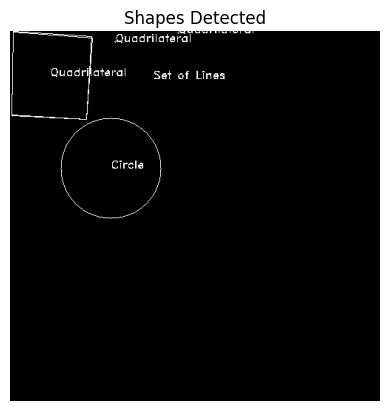

In [12]:
import cv2 
import numpy as np
import csv
import matplotlib.pyplot as plt

def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def polylines_to_image(paths_XYs, width=500, height=500, thickness=1):
    img = np.zeros((height, width), dtype=np.uint8)
    for XYs in paths_XYs:
        for XY in XYs:
            pts = np.array(XY, dtype=np.int32)
            cv2.polylines(img, [pts], isClosed=False, color=255, thickness=thickness)
    return img

def write_polylines_to_csv(contours, filename):
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        for contour in contours:
            for point in contour:
                csvwriter.writerow(point[0])
            csvwriter.writerow([])  # Add an empty row between contours

gray_image = polylines_to_image(read_csv_("content/isolated.csv"))

_, thresh_image = cv2.threshold(gray_image, 220, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image with the same dimensions as the original image
blank_image = np.zeros_like(gray_image)

for i, contour in enumerate(contours):
    if i == 0:
        continue

    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Circularity calculation: (4 * π * Area) / (Perimeter^2)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = (4 * np.pi * area) / (perimeter * perimeter)

    # Calculate the center of the shape
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

    if len(approx) < 3:
        # Draw lines for shapes with fewer than 3 vertices
        for j in range(len(contour) - 1):
            cv2.line(blank_image, tuple(contour[j][0]), tuple(contour[j + 1][0]), (255, 255, 255), 4)
        cv2.line(blank_image, tuple(contour[-1][0]), tuple(contour[0][0]), (255, 255, 255), 4)
        cv2.putText(blank_image, "Line", (cX, cY), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    elif len(approx) == 3:
        cv2.drawContours(blank_image, [approx], -1, (255, 255, 255), 1)
        cv2.putText(blank_image, "Triangle", (cX, cY), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    elif len(approx) == 4:
        cv2.drawContours(blank_image, [approx], -1, (255, 255, 255), 1)
        cv2.putText(blank_image, "Quadrilateral", (cX, cY), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    elif len(approx) == 5:
        cv2.drawContours(blank_image, [approx], -1, (255, 255, 255), 1)
        cv2.putText(blank_image, "Pentagon", (cX, cY), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    elif len(approx) == 6:
        cv2.drawContours(blank_image, [approx], -1, (255, 255, 255), 1)
        cv2.putText(blank_image, "Hexagon", (cX, cY), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    elif circularity > 0.7:  # A threshold value for circularity (0.7 can be adjusted)
        radius = int(np.sqrt(area / np.pi))
        cv2.circle(blank_image, (cX, cY), radius, (255, 255, 255), 1)
        cv2.putText(blank_image, "Circle", (cX, cY), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    else:
        cv2.putText(blank_image, "Set of Lines", (cX, cY), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)

# Write the detected contours to a CSV file
write_polylines_to_csv(contours, "output_polylines.csv")

# Display the image using matplotlib
plt.imshow(blank_image, cmap='gray')
plt.title('Shapes Detected')
plt.axis('off')
plt.show()